<a href="https://colab.research.google.com/github/allenlincg/aipractice/blob/main/Colab%E5%AF%A6%E4%BD%9C%EF%BC%9A%E5%BB%BA%E7%AB%8B_MNIST_%E6%89%8B%E5%AF%AB%E5%9C%96%E7%89%87%E7%9A%84_RNN_%E5%88%86%E9%A1%9E%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center">
  <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3004/logos/header.png"
  />
  <center>MNIST 手寫數字資料庫</center>
  <center>圖片來源: https://www.kaggle.com/</center>
</p>

## 1: 切換 TensorFlow 至 2.x 版

In [ ]:
%tensorflow_version 2.x

## 2: 載入套件及資料集

In [ ]:
%matplotlib inline
# Import some useful package
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, BoundedIntText

# For DNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# For RNN
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

# For training
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 3: 資料前處理 (Data Preprocessing)

在這裡，我們需要用兩種不同的方式來進行 MNIST 的 RNN 分類模型。

1. 每次看一個點：將每張圖片拉長成 784 維的向量，並當作一個 784 個時間點的資料，且每個時間的資料維度是 1。
2. 每次看一列向量：將每張圖片看成 28 個 28 維的列向量 (row vector)，並當作一個 28 個時間點的資料，且每個時間的資料維度是 28。

In [ ]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

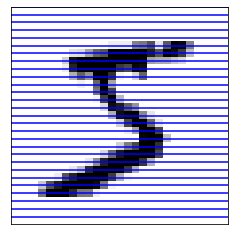

In [ ]:
plt.imshow(X_train[0], 'gray_r')
plt.xticks([])
plt.yticks([])
plt.xlim(0, 28)
plt.ylim(28, 0)
for i in range(28):
#     plt.vlines(i, 0, 28, colors='b')
    plt.hlines(i, 0, 28, colors='b')
plt.savefig('example_mnist_5_row')

Data shape: (28, 28)


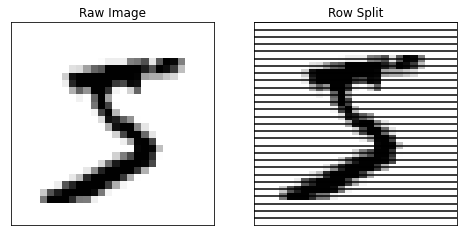

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0], 'gray_r')
plt.xticks([])
plt.yticks([])
plt.title('Raw Image')

plt.subplot(1, 2, 2)
plt.imshow(X_train[0], 'gray_r')
plt.xlim(0, 28)
plt.ylim(28, 0)
plt.xticks([])
plt.yticks([])
plt.title('Row Split')
for i in range(28):
    # plt.vlines(i, 0, 28, colors='b')
    plt.hlines(i, 0, 28, colors='k')

print("Data shape:", X_train[0].shape)

In [ ]:
# Normalize data range
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# Reshape each data as a vector
X_vec_train = X_train.reshape(-1, 28*28, 1)
X_vec_test = X_test.reshape(-1, 28*28, 1)

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## 4: 建立逐點輸入的 LSTM 分類模型

In [ ]:
model_pixel = Sequential()
model_pixel.add(SimpleRNN(40, input_shape=(784, 1)))
# model_pixel.add(LSTM(40, input_shape=(784, 1)))
# model_pixel.add(GRU(40, input_shape=(784, 1)))
model_pixel.add(Dense(10, activation='softmax'))
model_pixel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 40)                1680      
_________________________________________________________________
dense (Dense)                (None, 10)                410       
Total params: 2,090
Trainable params: 2,090
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_pixel.compile(loss='categorical_crossentropy',
                    optimizer=SGD(),
                    metrics=['categorical_accuracy'])

In [ ]:
training_history = model_pixel.fit(X_vec_train, y_train,
                                   batch_size=512,
                                   epochs=5,
                                   validation_data=(X_vec_test, y_test)
                                   )

## 5: 建立列向量當輸入的 LSTM 分類模型

In [ ]:
model_row = Sequential()
model_row.add(SimpleRNN(40, input_shape=(28, 28)))
model_row.add(Dense(10, activation='softmax'))
model_row.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 40)                2760      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                410       
Total params: 3,170
Trainable params: 3,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_row.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['categorical_accuracy'])

In [ ]:
training_history = model_row.fit(X_train, y_train,
                                 batch_size=512,
                                 epochs=5,
                                 validation_data=(X_test, y_test)
                                 )

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
27700/60000 [============>.................] - ETA: 7s - loss: 0.3454 - categorical_accuracy: 0.8992

KeyboardInterrupt: ignored

## 6: 視覺化預測結果

在這部分，我們提供簡單的視覺化方法來呈現神經網路的輸入與輸出結果

In [ ]:
model_list = ['model_pixel', 'model_row']
def visulization(model='model_row', idx=0):
    # Random pick one data from training set
    # idx = np.random.randint(X_train.shape[0])
    sample_x = X_test[idx]
    sample_y = y_test[idx]
    # Predict the class of random data
    if model=='model_pixel':
        model = model_pixel
        predict_y = model.predict(X_vec_test[idx:idx+1]).squeeze()
    else:
        model = model_row
        predict_y = model.predict(X_test[idx:idx+1]).squeeze()
    predict_label = predict_y.argmax()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    # Plot raw image
    ax1.imshow(sample_x, 'gray_r')
    ax1.set_title("Image Label: %s" %sample_y.argmax())

    # Plot prediction probability of each classes
    ax2.barh(np.arange(10), predict_y)
    ax2.patches[predict_label].set_facecolor('Red')
    ax2.set_title("Prediction Result: %d" %predict_label);
    if sample_y.argmax()==predict_y.argmax():
        print("預測正確!")
    else:
        print("預測失敗QQ")
    plt.show()

In [ ]:
interact(visulization, model=model_list, idx=BoundedIntText(value=5566, min=0, max=X_test.shape[0]-1));

interactive(children=(Dropdown(description='model', index=1, options=('model_pixel', 'model_row'), value='mode…

## 7: [練習] 建構屬於你自己的 RNN 分類模型

1. 使用堆疊 (stack) 的方式來建構 MNIST 上的分類模型

2. 使用不同的資料集 (如：CIFAR-10 或其他 Keras 提供的資料集，甚至是自己蒐集的資料等等) 來建立分類模型。

注意：若要使用語言相關的語料資料，建議要有自然語言處理 (NLP) 的背景及相關知識，才有辦法針對這類問題建構神經網路模型。

